In [1]:
using Surrogates
using Plots
using Statistics
using Random
using DataFrames
using Distances
using LinearAlgebra
using PolyChaos
default()

┌ Warning: Package Surrogates does not have PolyChaos in its dependencies:
│ - If you have Surrogates checked out for development and have
│   added PolyChaos as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Surrogates
│ Loading PolyChaos into Surrogates from project dependency, future warnings for Surrogates are suppressed.
└ @ nothing nothing:910


In [2]:
function splitdf(df, pct)
           @assert 0 <= pct <= 1
           ids = collect(axes(df, 1))
           shuffle!(ids)
           sel = ids .<= nrow(df) .* pct
           return DataFrame(view(df, sel, :)), DataFrame(view(df, .!sel, :))
       end

splitdf (generic function with 1 method)

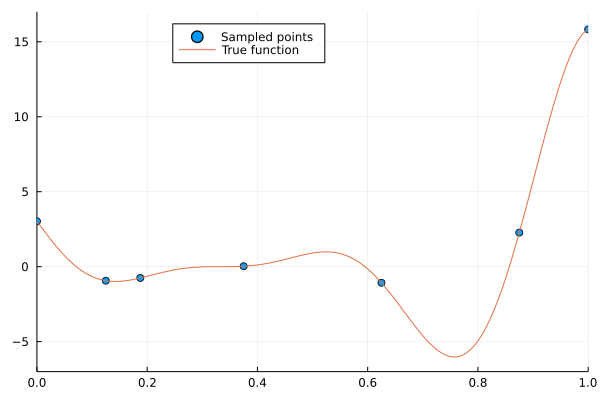

In [2]:
f(x) = (6 * x - 2)^2 * sin(12 * x - 4)

n_samples = 5
lower_bound = 0.0
upper_bound = 1.0

xs = lower_bound:0.001:upper_bound

x = sample(n_samples, lower_bound, upper_bound, SobolSample())
append!(x, lower_bound)
append!(x, upper_bound)
original_x = copy(x)
y = f.(x)
original_y = copy(y)

scatter(original_x, original_y, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17))
plot!(xs, f.(xs), label="True function", legend=:top)

In [8]:
minimum(broadcast(euclidean, [(0, 1), (1, 2)], [(1, 2)]))

0.0

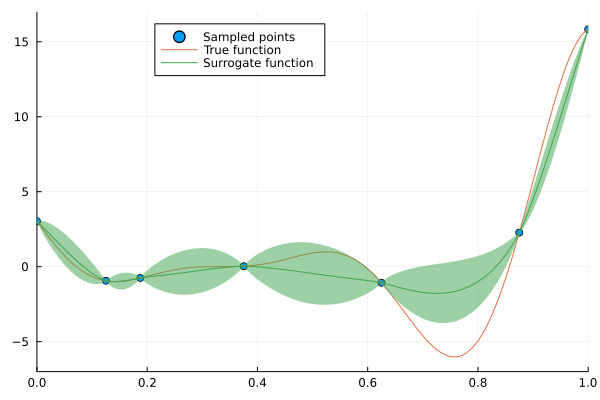

In [4]:
kriging_surrogate = Kriging(original_x, original_y, lower_bound, upper_bound, p=1.9);

plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

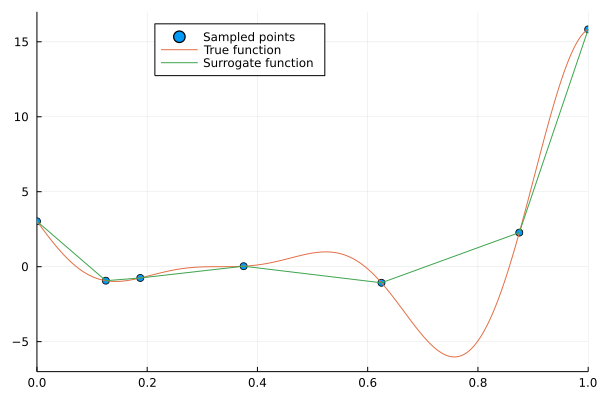

In [5]:
my_radial_basis = RadialBasis(original_x, original_y, lower_bound, upper_bound)
plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

In [9]:
# Implementing diversity
function calculate_variance(x, models)
    predictions = []
        for model in models
            prediction = model(x)
            append!(predictions, prediction)
        end
    return var(predictions, corrected=false)
end

function diversity_metric(prev_x, new_x, models, lambda = 0.5, mode=1)
    min_dist = minimum(broadcast(euclidean, prev_x, [new_x]))
    variance = calculate_variance(new_x, models)
    if mode == 0
        return (1 - lambda) * sqrt(variance) + lambda * min_dist
    elseif mode == 1
        return sqrt(variance) * min_dist
    end
end

diversity_metric (generic function with 3 methods)

In [10]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:8
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:1
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0, 0)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        println(sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

0.773
0.722
0.816
0.534
0.079
0.476
0.58
0.795


In [16]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:8
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:1
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0, 0)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        println(sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

0.773
0.722
0.816
0.534
0.079
0.476
0.58
0.795


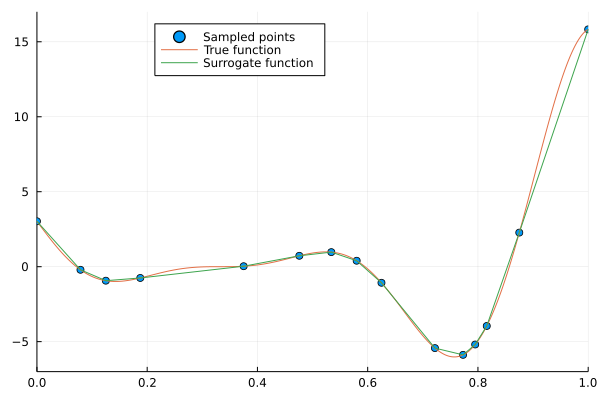

In [17]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

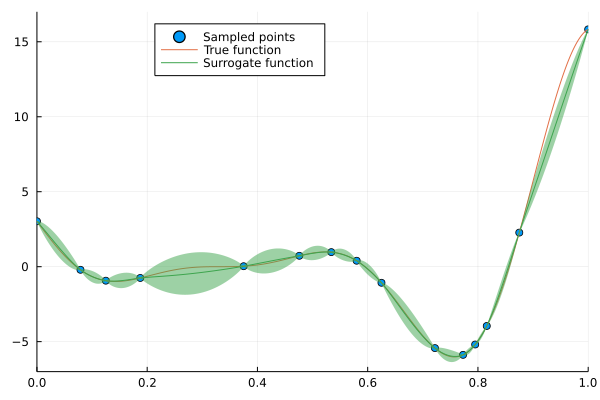

In [18]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [10]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:8
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:1
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate])
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        println(sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

0.75
0.5
0.812
0.688
0.563
0.063
0.781
0.281


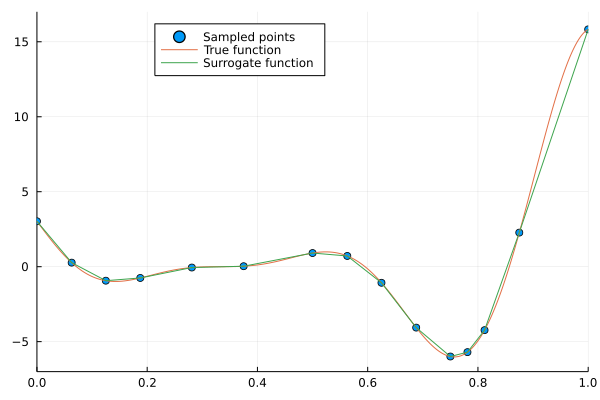

In [11]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

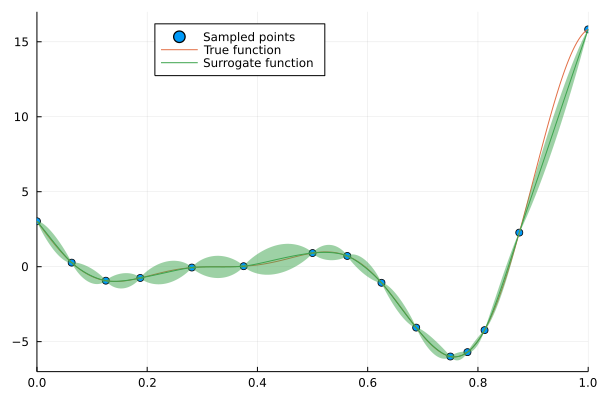

In [12]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [18]:
function booth(x)
    x1=x[1]
    x2=x[2]
    term1 = (x1 + 2*x2 - 7)^2;
    term2 = (2*x1 + x2 - 5)^2;
    y = term1 + term2;
end

booth (generic function with 1 method)

In [20]:
n_samples = 20
lower_bound = [-5.0, 0.0]
upper_bound = [10.0, 15.0]

xys = sample(n_samples, lower_bound, upper_bound, SobolSample())
push!(xys, (-5, 0))
push!(xys, (-5, 15))
push!(xys, (10, 0))
push!(xys, (10, 15))
zs = booth.(xys);

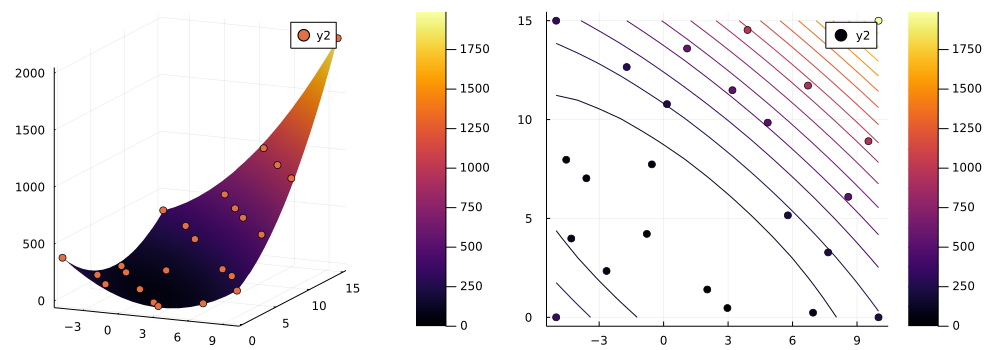

In [21]:
xs = [xy[1] for xy in xys]
ys = [xy[2] for xy in xys]
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> booth([x y])) # hide
scatter!(xs, ys, zs)
p2 = contour(x, y, (x, y) -> booth([x y]))
scatter!(xs, ys, marker_z=zs)
display(plot!(p1, p2, size=(1000,350), reuse=false))

In [238]:
radial_basis = RadialBasis(xys, zs,  lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{Tuple{Float64, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, LinearAlgebra.Transpose{Float64, Vector{Float64}}, Float64, Bool}) (generic function with 1 method)

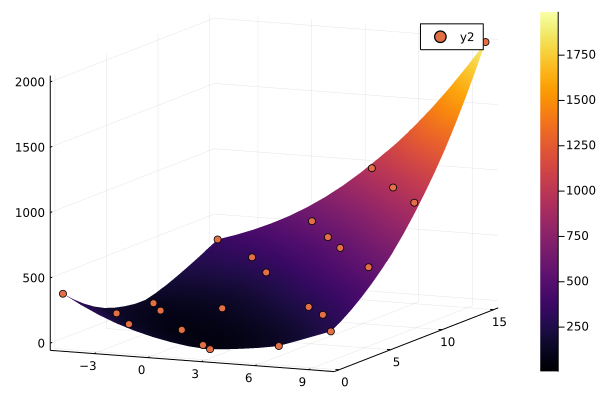

In [239]:
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> radial_basis([x y])) # hide
scatter!(xs, ys, zs)

In [18]:
function calculate_error(point, models, actual, mode="MSE")
    target = actual(point)
    errors = []
    for model in models
        prediction = model(point)
        append!(errors, abs(target - prediction))
    end
    if mode == "MSE"
        return mean(errors.^2)
    end
    if mode == "max"
        return maximum(errors)
    end
end

calculate_error (generic function with 2 methods)

In [14]:
function next_point_helper(prev_points, sample_space, models, lambda, mode)
    return argmax(broadcast(diversity_metric, Ref(prev_points), sample_space, Ref(models), Ref(lambda), Ref(mode)))
end 

next_point_helper (generic function with 1 method)

In [23]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
orig_train = sample(total_samples, lower_bound, upper_bound, SobolSample())
train = copy(orig_train)
test = sample(200, lower_bound, upper_bound, LatinHypercubeSample())
y_true = booth.(test)
error = Inf
models = [Kriging, RadialBasis]
while error > 5
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = next_point_helper(prev_points, train, [kriging_surrogate, my_radial_basis], 1, 1)
    append!(x, train[[max_index]])
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
    errors = []
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    mse_rad = norm(y_true - y_rad, 2)/length(test)
    mse_krig = norm(y_true - y_krig, 2)/length(test)
    error = (mse_rad + mse_krig) / 2
    println(error)
end

670
10.335005244578069
725
10.41226782151573
582
10.217520147875986
723
10.055884316284471
455
9.410546485566577
920
9.033830728610457
769
8.736258725777281
848
9.01038503177813
511
9.227037394125514
40
8.97582300924822
646
8.61824655248238
530
8.507895088114832
703
8.080877191584747
140
7.988017615366871
231
7.574295739291032
171
7.1003751924574265
544
6.823083662992193
973
6.628124168928867
953
6.539290998407615
321
6.6650790232444015
948
6.395957560106892
962
6.301757055234827
506
6.330299640652089
309
6.1186761195637205
141
5.829625923354143
505
5.554083934930409
966
5.399240657868177
234
5.254925775821735
683
5.109428678498664
100
4.986454946767941


In [25]:
kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])

(::Kriging{Vector{Any}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64, Matrix{Float64}, Float64, Matrix{Float64}}) (generic function with 2 methods)

In [53]:
size(train)

(970,)

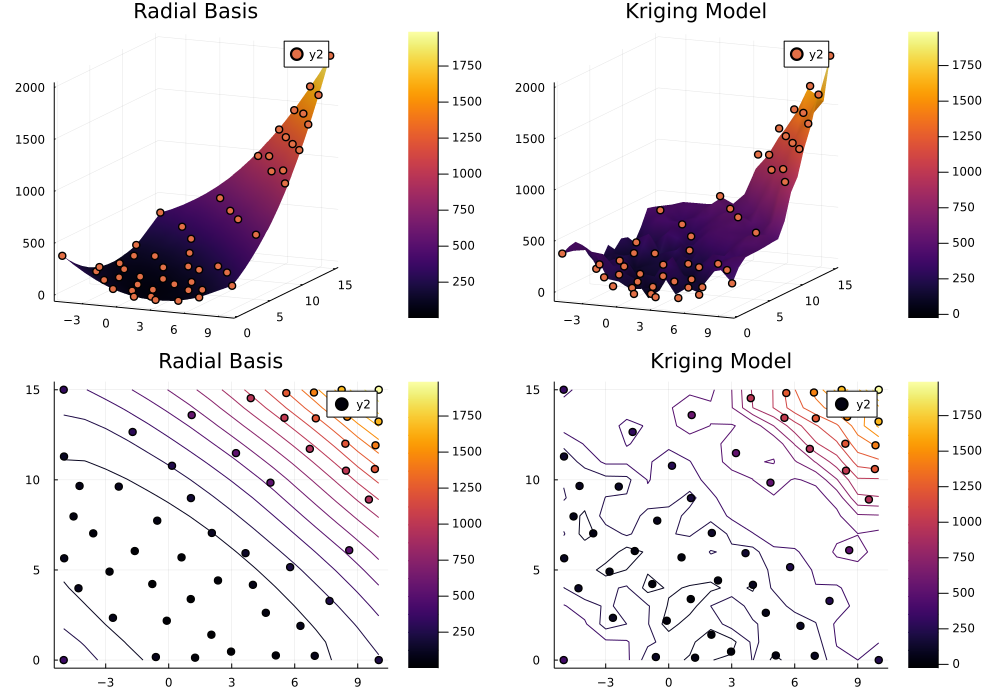

In [44]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [313]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
train = copy(orig_train)
# test = sample(200, lower_bound, upper_bound, LatinHypercubeSample())
# y_true = booth.(test)
error = Inf
while error > 5
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j]
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1, 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
    errors = []
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    mse_rad = norm(y_true - y_rad, 2)/length(test)
    mse_krig = norm(y_true - y_krig, 2)/length(test)
    error = (mse_rad + mse_krig) / 2
end

In [314]:
size(prev_points)

(74,)

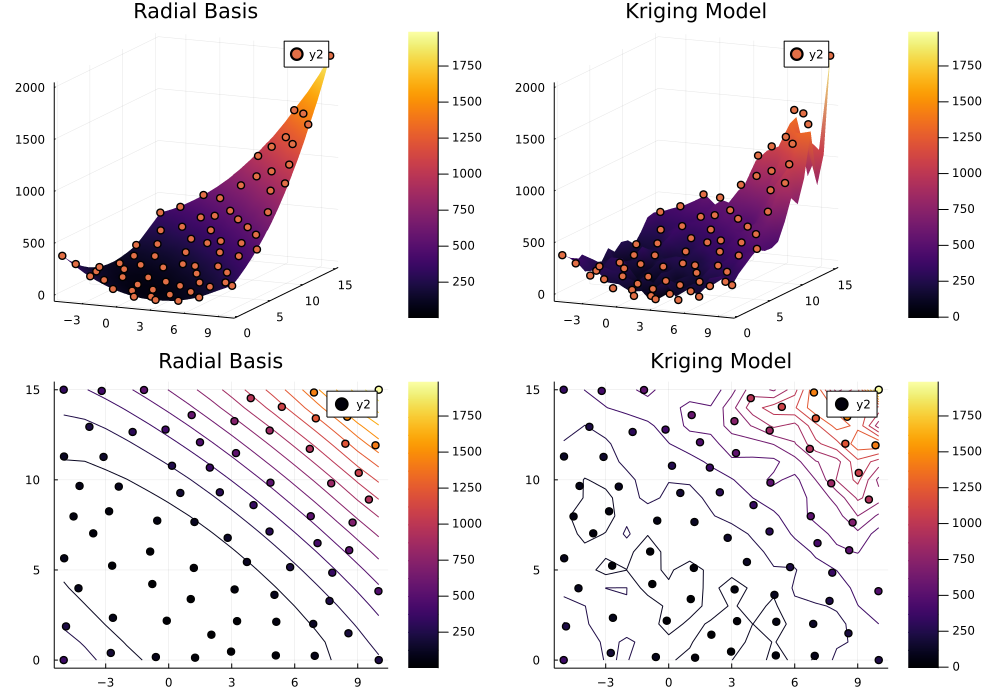

In [315]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [31]:
# Define the 2d Rosenbrock function
function Rosenbrock2d(x)
    x1 = x[1]
    x2 = x[2]
    return (1-x1)^2 + 100*(x2-x1^2)^2
end

Rosenbrock2d (generic function with 1 method)

In [316]:
n = 100     # Number of total sampling points
lb = [0.0,0.0]
ub = [8.0,8.0]
initial_n = 17      # Number of initial sampling points

17

In [338]:
xys = sample(initial_n,lb,ub,SobolSample());
push!(xys, (0.0, 0.0))
push!(xys, (0.0, 8.0))
push!(xys, (8.0, 0.0))
push!(xys, (8.0, 8.0))
zs = Rosenbrock2d.(xys);

In [389]:
total_samples = 2000
prev_points = copy(xys)
z = copy(zs)
orig_train = sample(total_samples, lb, ub, SobolSample())
train = copy(orig_train)
test = Iterators.product(0.:8/50:8., 0.:8/50:8.);
y_true = Rosenbrock2d.(test)
error = Inf
while error > 10 && length(prev_points) < 50
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j]
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 0, 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    mse_rad = norm(y_true - y_rad, 2)/length(test)
    mse_krig = norm(y_true - y_krig, 2)/length(test)
    error = (mse_rad + mse_krig) / 2
    println(error)
end

652.6279463841261
595.0689113034623
589.2869471684646
509.30799131757476
502.0752260881144
455.67427516678345
424.90202311743883
389.58547334886043
361.9778025824868
319.57091806434914
290.9079509262443
288.4188967123312
268.50330365430665
273.3772592379011
244.8196552161691
236.78345991965517
218.36821191761197
205.94308359317455
202.20369127755143
195.17266712032085
185.66893613401447
179.94363327516663
176.0787981166839
172.95515325383718
166.08733244435717
166.92889875722148
161.19182385064443
152.78072236236005
146.35790845958482


In [390]:
println(size(prev_points))

(50,)


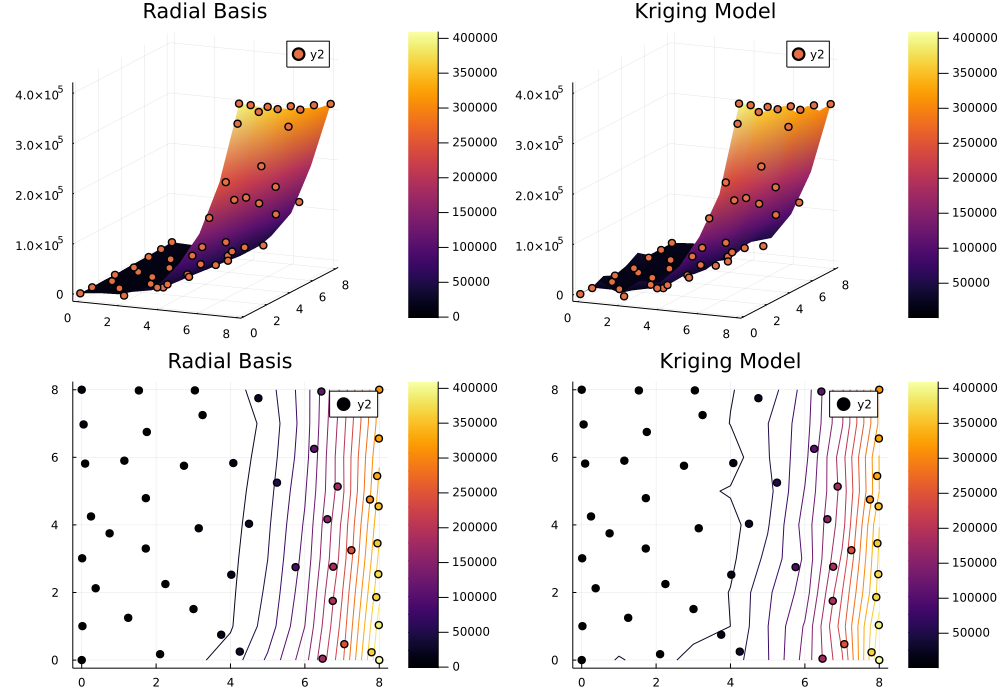

In [391]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [381]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lb, ub, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 1000 && length(prev_points) < 50
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j] 
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1, 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    mse_rad = norm(y_true - y_rad, 2)/length(test)
    mse_krig = norm(y_true - y_krig, 2)/length(test)
    error = (mse_rad + mse_krig) / 2
    println(error)
end

2269.1126978901334
2235.697853860027
2218.3064149541588
2209.996598079231
2196.727459172146
2307.7909427172335
2296.7786511927247
2285.346926116191
2273.9296956678672
2269.5917365107216
2266.7091841765796
2260.417204269879
2253.891518737633
2249.9848407726918
2371.5865606271445
2369.3859828766062
2367.388359376434
2366.767182782237
2365.893666925297
2358.378639971105
2348.6789603262796
2347.452845818251
2347.2796170371266
2346.2026831931585
2345.5930788606474
2339.6161320173633
2339.32656428637
2339.1932856135113
2387.2618817649154


In [382]:
println(size(prev_points))

(50,)


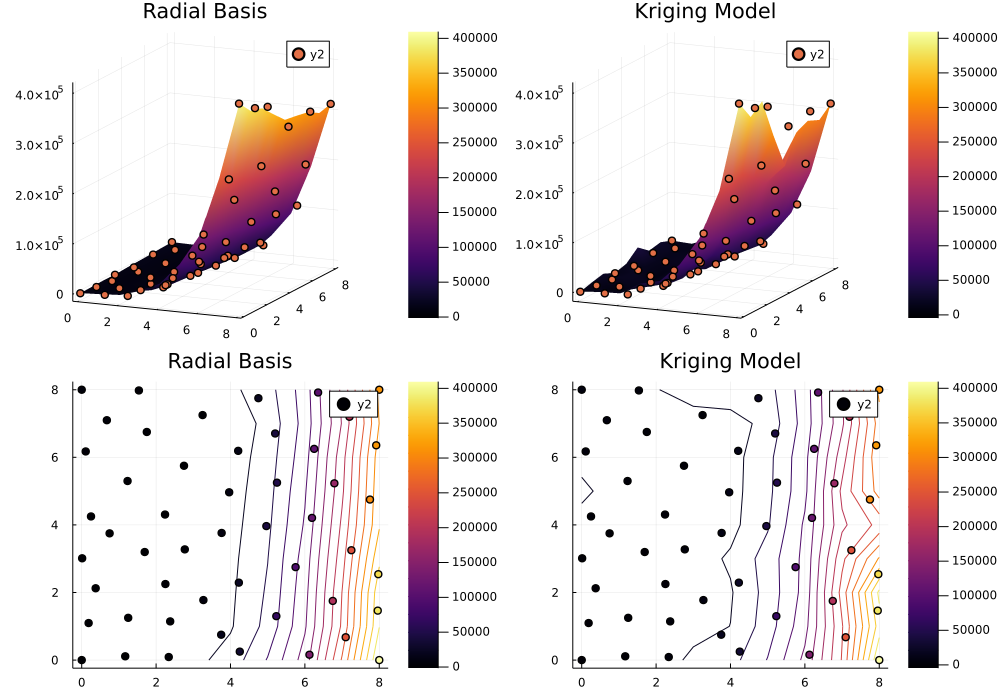

In [384]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [396]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lb, ub, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
errors = []
while error > 10 && length(prev_points) < 50
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j]
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate])
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    mse_rad = norm(y_true - y_rad, 2)/length(test)
    mse_krig = norm(y_true - y_krig, 2)/length(test)
    error = (mse_rad + mse_krig) / 2
    append!(errors, error)
    println(error)
end

652.6279463841261
634.8899140109429
597.9722998655727
521.277313426369
481.33643333220107
449.08280760584535
411.2380571265186
389.6797692852103
355.33886198397965
321.1914734269989
299.159235211627
270.4812209601786
257.1039510033147
238.5209224913271
225.11422145175703
212.30592167652878
204.06604380478169
195.9671195628661
188.460184616642
185.82537047951814
177.92981998658473
174.27606185321218
170.12029490538282
167.50351636047944
163.59778267247694
159.67763606772104
153.15065980411757
148.9314323055359
152.87813905999914


In [394]:
println(size(prev_points))

(50,)


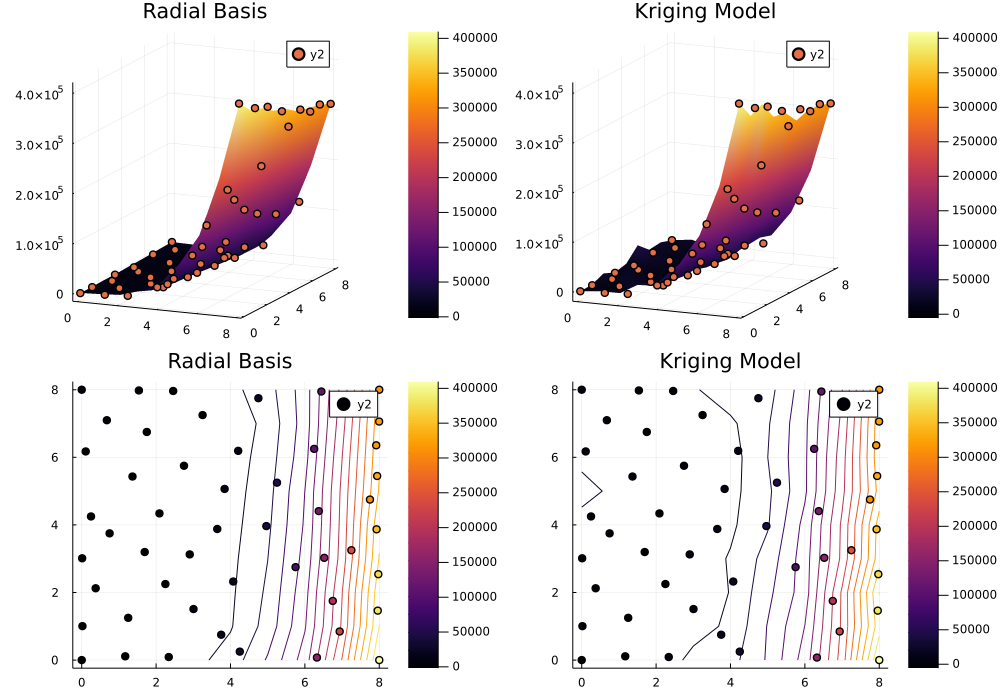

In [395]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

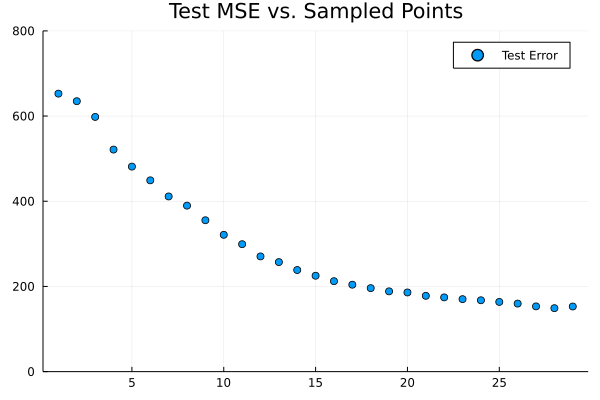

In [419]:
plot(1:length(errors), errors, seriestype=:scatter, label="Test Error", ylims=(0, 800), title="Test MSE vs. Sampled Points")

In [422]:
errors

29-element Vector{Any}:
 652.6279463841261
 634.8899140109429
 597.9722998655727
 521.277313426369
 481.33643333220107
 449.08280760584535
 411.2380571265186
 389.6797692852103
 355.33886198397965
 321.1914734269989
 299.159235211627
 270.4812209601786
 257.1039510033147
   ⋮
 195.9671195628661
 188.460184616642
 185.82537047951814
 177.92981998658473
 174.27606185321218
 170.12029490538282
 167.50351636047944
 163.59778267247694
 159.67763606772104
 153.15065980411757
 148.9314323055359
 152.87813905999914

In [420]:
random_sample = sample(50, lb, ub, LatinHypercubeSample())
z = Rosenbrock2d.(random_sample)
test = Iterators.product(0.:8/50:8., 0.:8/50:8.);
y_true = Rosenbrock2d.(test)
my_radial_basis = RadialBasis(random_sample, z, lb, ub)
my_kriging_model = Kriging(random_sample, z, lb, ub, p=[1.9, 1.9])
y_rad = my_radial_basis.(test)
y_krig = my_kriging_model.(test)
mse_rad = norm(y_true - y_rad, 2)/length(test)
mse_krig = norm(y_true - y_krig, 2)/length(test)
error = (mse_rad + mse_krig) / 2


440.51330039926137

In [404]:
length(errors)

29

In [107]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lb, ub, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 10 ^ 7
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], Rosenbrock2d))
    end
    error = mean(errors)
end

In [108]:
println(size(prev_points))

(164,)


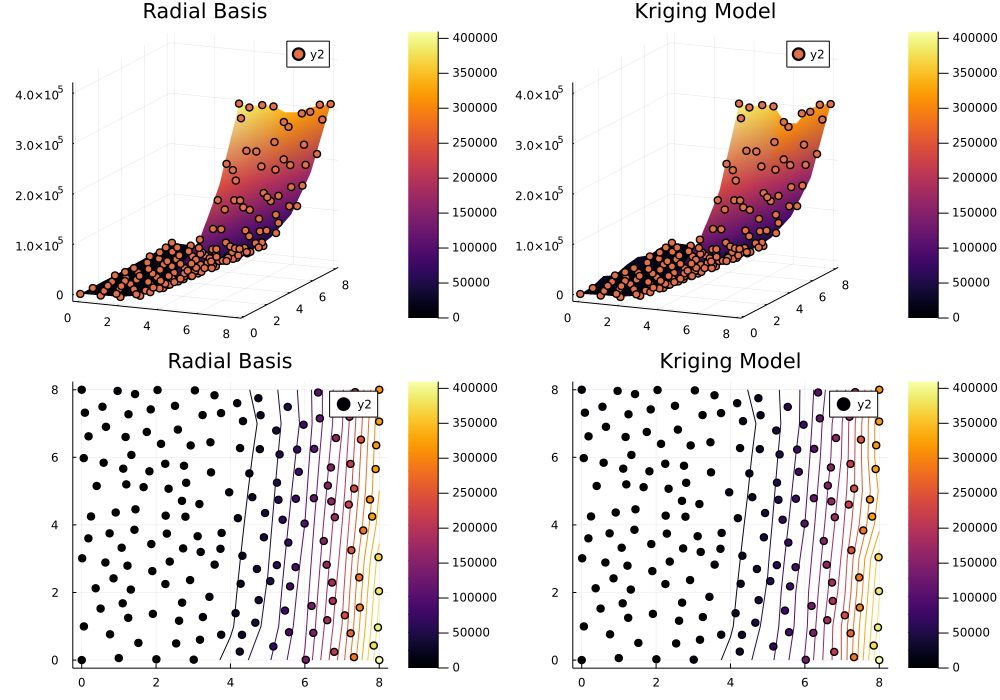

In [109]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

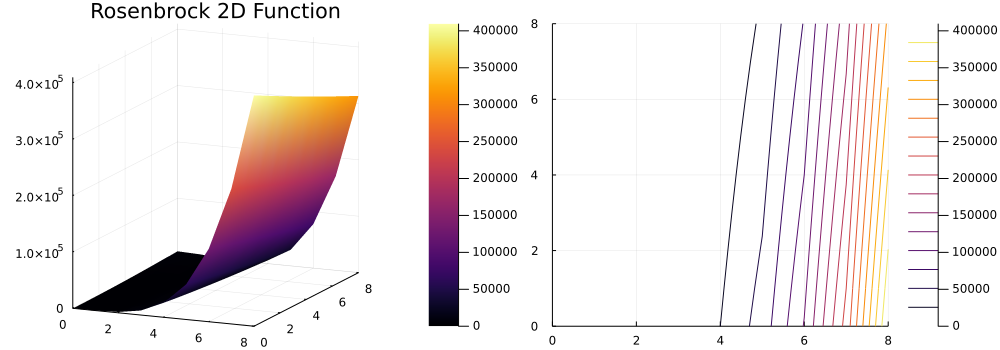

In [374]:
x = 0.0:8.0
y = 0.0:8.0
p1 = surface(x, y, (x, y) -> Rosenbrock2d([x y]), title="Rosenbrock 2D Function")
p2 = contour(x, y, (x, y) -> Rosenbrock2d([x y]))
display(plot!(p1, p2, size=(1000,350), reuse=false))